# Introduction

In this short, fun analysis, we will have a look at [Hans Lienesch's quest to rate all the instant ramen the world has to offer](https:\\www.ramenrater.com).

Personally, my current top three favourites are Indomie's Mi Goreng, Nongshim's Shin Ramyun and MyKuali's Penang White Curry Noodle. Let's see what he has to say about these ramen in his ratings! 

In [1]:
#### To-do ####
# Join tables
# Rename values for 'Brand'
# Clean 'Country'
# Clean 'Stars'

In [2]:
# Initialisation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    from fuzzywuzzy import process

sns.set_style('ticks')
plt.rc("axes.spines", top=False, right=False)

df = pd.read_excel('Dataset\The-Big-List-20210117.xlsx')

We'll start by checking out the data and doing some data cleaning before proceeding further.


In [3]:
# A quick look at the dataframe
print(df.info())
display(df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3702 entries, 0 to 3701
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Review #  3702 non-null   int64  
 1   Brand     3702 non-null   object 
 2   Variety   3702 non-null   object 
 3   Style     3702 non-null   object 
 4   Country   3702 non-null   object 
 5   Stars     3702 non-null   object 
 6   T         0 non-null      float64
dtypes: float64(1), int64(1), object(5)
memory usage: 202.6+ KB
None


,Review #,Brand,Variety,Style,Country,Stars,T
347,3355,Vite Ramen,Garlic Pork Instant Noodle Soup v1.1,Pack,United States,4,NaN
2045,1657,Shan,Shoop Instant Noodles Bombay Biryani Flavour,Pack,Pakistan,2.75,NaN
1389,2313,Xiao Ban Mian,Sesame Oil With Garlic Flavor Thin Noodle,Pack,Taiwan,3.5,NaN
1620,2082,Nissin,Cup Noodles Pork Chowder Flavour,Cup,Hong Kong,3.5,NaN
2555,1147,Asian Thai Foods,Rumpum Chicken Soup Base,Pack,Nepal,3.5,NaN


In [4]:
# Column T is empty and can be discarded
df.drop(labels='T', axis=1, inplace=True)

In [5]:
print('\nNumber of rows with duplicates:', df.duplicated().sum(),'\n')

# Too many unique values to go through manually
print('There are', len(df.Brand.unique()), 'unique brands in the dataset and',
       len(df.Variety.unique()), 'unique varieties of instant noodles in the dataset.')


Number of rows with duplicates: 0 

There are 544 unique brands in the dataset and 3449 unique varieties of instant noodles in the dataset.


In [6]:
# Checking for inconsistencies/typos
print('Unique values for \'Style\'\n\n', sorted(df.Style.unique()))
print('\n----\n')
print('Unique values for \'Country\'\n\n', sorted(df.Country.unique()))
print('\n----\n')

# print(sorted(df.Stars.unique())) # Gives an error
print('Unique values for \'Stars\'\n\n', set(df.Stars.tolist()))
print('\n----')

Unique values for 'Style'

 ['Bar', 'Bowl', 'Box', 'Can', 'Cup', 'Pack', 'Restaurant', 'Tray']

----

Unique values for 'Country'

 ['Australia', 'Bangladesh', 'Brazil', 'Cambodia', 'Canada', 'China', 'Colombia', 'Dubai', 'Estonia', 'Fiji', 'Finland', 'France', 'Germany', 'Ghana', 'Holland', 'Hong Kong', 'Hungary', 'India', 'Indonesia', 'Israel', 'Italy', 'Japan', 'Malaysia', 'Mexico', 'Myanmar', 'Nepal', 'Netherlands', 'New Zealand', 'Nigeria', 'Pakistan', 'Peru', 'Philippines', 'Phlippines', 'Poland', 'Portugal', 'Russia', 'Russian Federation', 'Sarawak', 'Singapore', 'Souh Korea', 'South Korea', 'Spain', 'Sweden', 'Taiwan', 'Thailand', 'UK', 'USA', 'Ukraine', 'United Kingdom', 'United States', 'Vietnam']

----

Unique values for 'Stars'

 {0.75, 0, 2.5, 3.75, 4, 3.5, 4.5, 5, 4.25, 3, 3.25, 4.75, 2, 1.25, 2.75, 0.5, 2.25, datetime.datetime(2017, 5, 5, 0, 0), datetime.datetime(2017, 5, 4, 0, 0), 3.125, 2.125, 4.125, '4.5/5', 1, 1.5, 0.25, 1.75, 1.1, 2.1, 2.85, 3.1, 3.6, 'NR', 0.1, 2.8

Whew! 

It does seem like the 'Country' (e.g., USA <-> United States) and 'Stars' (e.g., datetime values!?) columns require a bit of cleaning<sup>**</sup>, however we will skip these for now and get to them soon.

A quick look in the dataframe (via other means) also revealed some inconsistencies and typos for 'Brand' as well. A technique that we will be using here is fuzzy matching to match similar strings using [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) as a metric. The Levenshtein distance measures how far apart two sequences are, with very similar sequences giving a higher score ratio. 

<sup>**</sup>It would be very easy to clean these values in the Excel spreadsheet and then re-import the data, but this is a great chance to get some experience and practice doing data cleansing in Python!

In [7]:
# Data cleaning for 'Brand' column
brand_list = sorted(df.Brand.unique().tolist())

# Consolidating brands with very similar names using fuzzy matching
brand_df = pd.DataFrame(columns=['String','String occurences','Match','Match occurences','Ratio %'])

for i, brand in enumerate(brand_list, start=1):
    # Match next 5 in list, escape loop if at last brand in list (i==k)
    k = i+5 if i+5 < len(brand_list) else len(brand_list)
    if i == k:
        break
    str2match = brand_list[i:k]
    topMatch = process.extractOne(brand, str2match)[0]
    matchPct = process.extractOne(brand, str2match)[1]
    # Append to brand_df if match is above 75%
    if matchPct >= 75:
        brand_df = brand_df.append({'String':brand,
                                    'String occurences': (df.Brand == brand).sum(),
                                    'Match':topMatch,
                                    'Match occurences': (df.Brand == topMatch).sum(),
                                    'Ratio %':matchPct},
                                     ignore_index=True)

brand_df = brand_df.sort_values(by='Ratio %', ascending=False).reset_index(drop=True)
brand_df


,String,String occurences,Match,Match occurences,Ratio %
0,TableMark,2,Tablemark,3,100
1,Goku Uma,3,Goku-Uma,4,100
2,Nissin Miojo,10,Nissin-Miojo,2,100
3,Mamee Shinsegae,2,Mamee-Shinsegae,1,100
4,MAMA,33,Mama,71,100
...,...,...,...,...,...
87,7 Select/Nissin,1,7-Eleven / Nissin,1,76
88,Baijia,11,Baixiang Noodles,5,75
89,Yamamori,2,Yamamoto,7,75
90,Samyang Foods,103,Sanyo Foods,1,75


# WIP

Let's join the table with the re-reviewed instant ramen as we will be using the joined table to see if scores have changed for better or for worse further down the analysis.

In [8]:
# Getting the re-reviewed sheet from the dataset
# 'Date' column discarded as it is not used in the original dataset
df_rereview = pd.read_excel('Dataset\The-Big-List-20210117.xlsx', sheet_name='Re-Reviewed', usecols=range(1,6))
print(df_rereview.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Brand    80 non-null     object 
 1   Variety  80 non-null     object 
 2   Style    80 non-null     object 
 3   Country  80 non-null     object 
 4   Stars    80 non-null     float64
dtypes: float64(1), object(4)
memory usage: 3.2+ KB
None


In [9]:
# Since the df_rereview dataframe is smaller, we can manually do a quick check for obvious inconsistencies/typos
print(sorted(df_rereview.Brand.unique()))
print(sorted(df_rereview.Variety.unique()))
print(sorted(df_rereview.Style.unique()))
print(sorted(df_rereview.Country.unique()))
print(sorted(df_rereview.Stars.unique()))

["Annie Chun's", 'FMF', 'Indomie', 'Koka', 'Mama', 'Maruchan', 'Myojo', 'Nissin', 'Nongshim', 'Ottogi', 'Paldo', 'Payless', 'Quickchow', 'Sakurai Foods', 'Samyang', 'Sapporo Ichiban', 'Ve Wong', 'Wei Lih', 'Wu Mu', 'emart']
['Ansungtangmyun', 'Beef', 'Beef Flavor Ramen', 'Bekse Curry Myon', 'Bibim Men', 'Bowl Noodle Soup Kimchi Flavor', 'Bowl Noodle Soup Spicy Chicken', 'Champong', 'Chapagetti', 'Chicken Curry', 'Chow Mein', 'Chow Tomato', 'Curliy Noodles With Chicken & Chilli Paddi Flavor', 'Curly Noodles With Grilled Chicken', 'Curry', 'Dare You! Habanero Ramen', 'Demae Ramen Chicken', 'Demae Ramen Sesame Oil', 'Gomtang', 'Hooroorook', 'Hwa King Cup Noodle Soup', 'Hwa Ramyun Soy Peptide', 'Ippei-chan Yakisoba', 'Jah Jan Mien', 'Jin Ramen (Hot)', 'Jinjja Jinjja', 'Jjajangmen Chajang Noodle', 'Jumbo Pack Pork Flavour Oriental Style Instant Noodles', 'Kal Guk Soo', 'Kimchi Pot Stew King Cup', 'Kimchi Ramyun', 'Kokomen King Cup', 'Kung Fu Artificial Chicken Flavor Instant Oriental Noodle

In [10]:
# Hans had reviewed the same instant ramen a few times
# A new dataframe with the re-re-reviewed rows is created to join to the original table
# Only the 2nd occurrence of the duplicates is kept in this dataframe
dupe_rows = df_rereview.duplicated(subset=['Brand', 'Variety', 'Style', 'Country'])

print('\nNumber of rows with more than one re-reviews:', dupe_rows.sum(), '\n')

df_rereview = df_rereview.merge(df_rereview[dupe_rows],
                                on=['Brand', 'Variety', 'Style', 'Country'],
                                how='left',
                                suffixes=['_2', '_3'])


Number of rows with more than one re-reviews: 7 



In [11]:
# Discarding rows with the duplicates, keeping the first entry
df_rereview.drop_duplicates(subset=['Brand', 'Variety', 'Style', 'Country'],
                            inplace=True)

print(df_rereview.info())
display(df_rereview.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 0 to 79
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Brand    73 non-null     object 
 1   Variety  73 non-null     object 
 2   Style    73 non-null     object 
 3   Country  73 non-null     object 
 4   Stars_2  73 non-null     float64
 5   Stars_3  7 non-null      float64
dtypes: float64(2), object(4)
memory usage: 4.0+ KB
None


,Brand,Variety,Style,Country,Stars_2,Stars_3
0,Nongshim,Shin Ramyun,Pack,South Korea,3.0,4.0
1,Sapporo Ichiban,Chow Mein,Pack,USA,4.5,5.0
2,Ottogi,Jin Ramen (Hot),Pack,South Korea,3.5,NaN
3,Quickchow,Pancit Palabok,Pack,Philippines,2.5,NaN
4,Indomie,Special Curly Noodles With Grilled Chicken,Pack,Indonesia,5.0,NaN


Looks like the join was successful! Now we join this to the main dataframe using an outer join so that we can pick out mismatches and correct them if required.

In [12]:
### WIP, need to fix consistency issues with Brand, Variety and Country with main df first before proceeding.


# Using outer join instead of left join to check which rows did not match
df2 = df.merge(df_rereview, on=['Brand', 'Variety', 'Style', 'Country'], how='outer')
df3 = df2[df2['Stars'].isnull()]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749 entries, 0 to 3748
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Review #  3702 non-null   float64
 1   Brand     3749 non-null   object 
 2   Variety   3749 non-null   object 
 3   Style     3749 non-null   object 
 4   Country   3749 non-null   object 
 5   Stars     3702 non-null   object 
 6   Stars_2   75 non-null     float64
 7   Stars_3   9 non-null      float64
dtypes: float64(3), object(5)
memory usage: 263.6+ KB


# 1. Which brand among those that Hans has eaten has the highest variety of flavours?

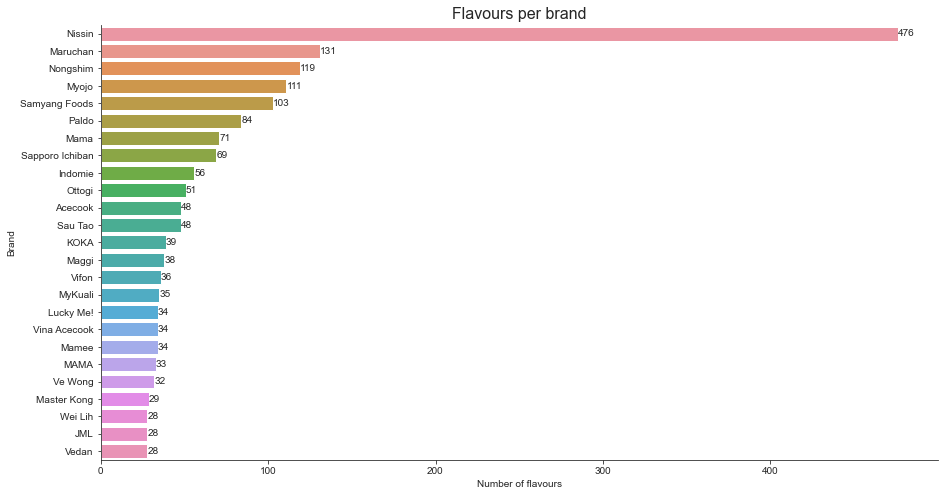

In [13]:
# Top 25 brands by number of flavours
flav = df.groupby(['Brand']).size().sort_values(ascending=False)[:25]

plt.figure(figsize=(15,8))
flav_plot = sns.barplot(x=flav.values, y=flav.index)

plt.bar_label(flav_plot.containers[0]) # Annotating values at end of the bar
plt.xlabel('Number of flavours')
plt.title('Flavours per brand', size=16)
plt.show()

### Nissin dominates the instant ramen scene with 476 flavours, 3.6 times more than its closest competitor.